In [1]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.9 MB/s eta 0:00:0000:01


In [2]:
# ==============================================================================
# CELL 1: Environment Setup
# ==============================================================================

# Install required packages
import os
import sys

print("📦 Installing dependencies...")
os.system('pip install -q wfdb safetensors timm einops')

# Clone ESI repository if not exists
if not os.path.exists("ESI"):
    print("⬇️ Cloning ESI repository...")
    os.system('git clone https://github.com/comp-well-org/ESI.git')
    
# Add ESI to path
esi_path = os.path.join(os.getcwd(), "ESI")
if esi_path not in sys.path:
    sys.path.append(esi_path)

# Standard imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
import wfdb
from safetensors.torch import load_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score, matthews_corrcoef
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Verify ESI import
try:
    from model.convnextv2 import convnextv2_base
    print("✅ ESI architecture imported successfully")
except ImportError as e:
    print(f"❌ Failed to import ESI: {e}")
    sys.exit(1)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("\n✅ Environment setup complete!")

📦 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.2 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


⬇️ Cloning ESI repository...


Cloning into 'ESI'...


✅ ESI architecture imported successfully
🖥️ Using device: cuda:0

✅ Environment setup complete!


In [6]:
# ==============================================================================
# CELL 2: Hyperparameters
# ==============================================================================

class Config:
    # ============= PATHS =============
    DATA_DIR = '/kaggle/input/apneaecg/apnea-ecg-database-1.0.0'
    CHECKPOINT_PATH = "/kaggle/input/esi-model/model.safetensors"
    OUTPUT_DIR = "/kaggle/input/model-checkpoints-apnea/outputs"
    
    # ============= DATA PARAMETERS =============
    FS = 100                    # Sampling frequency (Hz)
    SEQ_LENGTH = 6000           # 60 seconds * 100 Hz
    OVERLAP = 0.5               # 50% overlap for data augmentation
    
    # ============= MODEL PARAMETERS =============
    ESI_EMBEDDING_DIM = 1024    # ESI backbone output dimension
    HIDDEN_DIM = 256            # LSTM hidden dimension
    LSTM_LAYERS = 2             # Number of LSTM layers
    DROPOUT = 0.3               # Dropout rate
    
    # ============= TRAINING PARAMETERS =============
    BATCH_SIZE = 32
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    POS_WEIGHT = 2.0            # Weight for apnea class (handles imbalance)
    
    # ============= DATA SPLIT =============
    TEST_SIZE = 0.2             # 20% for testing
    VAL_SIZE = 0.1              # 10% for validation
    
    # ============= GRADUAL UNFREEZING SCHEDULE =============
    UNFREEZE_SCHEDULE = {
        0: [],                  # Epochs 0-4: Only head
        3: ['stages.3'],        # Epoch 5: Unfreeze last stage
        6: ['stages.2', 'stages.3']  # Epoch 10: Unfreeze last 2 stages
    }
    
    # ============= DEVICE =============
    DEVICE = device
    
    # Create output directories
    @classmethod
    def create_dirs(cls):
        os.makedirs(cls.OUTPUT_DIR, exist_ok=True)
        os.makedirs(os.path.join(cls.OUTPUT_DIR, "checkpoints"), exist_ok=True)

# Initialize config
config = Config()
config.create_dirs()

# Print configuration
print("⚙️ CONFIGURATION")
print("="*60)
print(f"Data Directory:      {config.DATA_DIR}")
print(f"Checkpoint Path:     {config.CHECKPOINT_PATH}")
print(f"Device:              {config.DEVICE}")
print(f"Sequence Length:     {config.SEQ_LENGTH} samples ({config.SEQ_LENGTH/config.FS}s)")
print(f"Overlap:             {config.OVERLAP*100}%")
print(f"Batch Size:          {config.BATCH_SIZE}")
print(f"Learning Rate:       {config.LEARNING_RATE}")
print(f"Epochs:              {config.NUM_EPOCHS}")
print(f"Hidden Dimension:    {config.HIDDEN_DIM}")
print(f"LSTM Layers:         {config.LSTM_LAYERS}")
print("="*60)

⚙️ CONFIGURATION
Data Directory:      /kaggle/input/apneaecg/apnea-ecg-database-1.0.0
Checkpoint Path:     /kaggle/input/esi-model/model.safetensors
Device:              cuda:0
Sequence Length:     6000 samples (60.0s)
Overlap:             50.0%
Batch Size:          32
Learning Rate:       0.0001
Epochs:              25
Hidden Dimension:    256
LSTM Layers:         2


In [7]:
# ==============================================================================
# CELL 3: Data Parsing with Proper Error Handling
# ==============================================================================

def prepare_apnea_segments(data_dir, seq_length=6000, overlap=0.0):
    """
    Parse Apnea-ECG database with robust error handling
    """
    files = [f for f in os.listdir(data_dir) if f.endswith('.dat')]
    records = [f.replace('.dat', '') for f in files if f.startswith(('a', 'b', 'c'))]
    records = sorted(list(set(records)))
    
    all_segments = []
    stride = int(seq_length * (1 - overlap))
    
    print(f"📊 Processing {len(records)} records...")
    
    failed_records = []
    
    for rec in tqdm(records, desc="Parsing records"):
        rec_path = os.path.join(data_dir, rec)
        try:
            # Read annotations
            ann = wfdb.rdann(rec_path, extension='apn')
            labels = ann.symbol
            
            # Read header
            header = wfdb.rdheader(rec_path)
            max_len = header.sig_len
            n_channels = header.n_sig
            
            # TEST READ: Try to read a small sample first
            try:
                # Try reading first channel
                test_signal, test_fields = wfdb.rdsamp(rec_path, sampfrom=0, sampto=min(100, max_len))
                
                if test_signal is None or len(test_signal) == 0:
                    print(f"⚠️ Skipping {rec}: Empty signal")
                    failed_records.append(rec)
                    continue
                
                # Check if signal contains valid data
                if np.isnan(test_signal).all() or np.isinf(test_signal).all():
                    print(f"⚠️ Skipping {rec}: Invalid signal data")
                    failed_records.append(rec)
                    continue
                    
            except Exception as e:
                print(f"⚠️ Skipping {rec}: Failed test read - {e}")
                failed_records.append(rec)
                continue
            
            # Create segments with stride
            for i, label_char in enumerate(labels):
                start = i * stride
                end = start + seq_length
                
                if end > max_len:
                    continue
                
                # Map labels: A=1 (Apnea), N=0 (Normal)
                if label_char == 'A':
                    all_segments.append((rec, start, end, 1))
                elif label_char == 'N':
                    all_segments.append((rec, start, end, 0))
                    
        except FileNotFoundError:
            print(f"⚠️ Skipping {rec}: Annotation file not found")
            failed_records.append(rec)
            continue
        except Exception as e:
            print(f"⚠️ Skipping {rec}: {str(e)[:50]}")
            failed_records.append(rec)
            continue
    
    print(f"\n✅ Successfully processed {len(records) - len(failed_records)}/{len(records)} records")
    if failed_records:
        print(f"⚠️ Failed records: {', '.join(failed_records[:5])}{'...' if len(failed_records) > 5 else ''}")
    
    return all_segments


print("\n🔍 STEP 1: DATA PARSING (FIXED)")
print("="*60)

segments = prepare_apnea_segments(config.DATA_DIR, config.SEQ_LENGTH, config.OVERLAP)

if len(segments) == 0:
    raise ValueError("❌ No segments found! Check DATA_DIR path.")

labels = [s[3] for s in segments]
normal_count = labels.count(0)
apnea_count = labels.count(1)

print(f"\n📈 DATASET STATISTICS")
print(f"Total Segments:      {len(segments):,}")
print(f"Normal Segments:     {normal_count:,} ({100*normal_count/len(segments):.1f}%)")
print(f"Apnea Segments:      {apnea_count:,} ({100*apnea_count/len(segments):.1f}%)")
print("="*60)


🔍 STEP 1: DATA PARSING (FIXED)
📊 Processing 43 records...


Parsing records:   0%|          | 0/43 [00:00<?, ?it/s]


✅ Successfully processed 43/43 records

📈 DATASET STATISTICS
Total Segments:      21,000
Normal Segments:     12,877 (61.3%)
Apnea Segments:      8,123 (38.7%)


In [8]:
# ==============================================================================
#  CELL 4: Train/Val/Test Split with ROBUST Normalization
# ==============================================================================

print("\n📊 STEP 2: DATA SPLITTING (FIXED)")
print("="*60)

labels = [s[3] for s in segments]

train_val_seg, test_seg = train_test_split(
    segments, test_size=config.TEST_SIZE, random_state=SEED, stratify=labels
)

train_val_labels = [s[3] for s in train_val_seg]
val_ratio = config.VAL_SIZE / (1 - config.TEST_SIZE)

train_seg, val_seg = train_test_split(
    train_val_seg, test_size=val_ratio, random_state=SEED, stratify=train_val_labels
)

print(f"Train: {len(train_seg):,} | Val: {len(val_seg):,} | Test: {len(test_seg):,}")


# FIXED: Compute normalization statistics with robust error handling
print("\n🔢 Computing normalization statistics (ROBUST VERSION)...")

sample_size = min(500, len(train_seg))  # Reduced sample size for speed
sample_indices = np.random.choice(len(train_seg), sample_size, replace=False)

all_values = []
failed_samples = 0
successful_samples = 0

for idx in tqdm(sample_indices, desc="Sampling"):
    rec, start, end, _ = train_seg[idx]
    file_path = os.path.join(config.DATA_DIR, rec)
    
    try:
        # Read signal - try without specifying channels first
        signal, fields = wfdb.rdsamp(file_path, sampfrom=start, sampto=end)
        
        if signal is None or len(signal) == 0:
            failed_samples += 1
            continue
        
        # Take first channel if multi-channel
        if signal.ndim > 1:
            signal = signal[:, 0:1]
        
        # Check for NaN/Inf
        if np.isnan(signal).any() or np.isinf(signal).any():
            failed_samples += 1
            continue
        
        # Check if signal has reasonable values
        if np.abs(signal).max() > 1e6:  # Unreasonably large values
            failed_samples += 1
            continue
        
        all_values.extend(signal.flatten())
        successful_samples += 1
        
    except Exception as e:
        failed_samples += 1
        continue

print(f"\n✅ Successfully sampled {successful_samples}/{sample_size} segments")
print(f"⚠️ Failed samples: {failed_samples}")

if len(all_values) == 0:
    print("\n❌ CRITICAL ERROR: No valid data found!")
    print("Possible issues:")
    print("1. Wrong DATA_DIR path")
    print("2. Corrupted data files")
    print("3. Incompatible file format")
    raise ValueError("No valid ECG data could be loaded")

# Convert to numpy array
all_values = np.array(all_values)

# Remove outliers for robust statistics
print("\n📊 Computing robust statistics...")
q1 = np.percentile(all_values, 25)
q3 = np.percentile(all_values, 75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

# Filter outliers
filtered_values = all_values[(all_values >= lower_bound) & (all_values <= upper_bound)]

print(f"Original samples: {len(all_values):,}")
print(f"After outlier removal: {len(filtered_values):,}")
print(f"Outliers removed: {len(all_values) - len(filtered_values):,}")

# Compute statistics
dataset_mean = np.mean(filtered_values)
dataset_std = np.std(filtered_values)

# Sanity checks
if np.isnan(dataset_mean) or np.isnan(dataset_std):
    print("\n❌ CRITICAL: Computed statistics are NaN!")
    print("Using fallback normalization: mean=0, std=1")
    dataset_mean = 0.0
    dataset_std = 1.0
elif dataset_std < 1e-6:
    print("\n⚠️ WARNING: Standard deviation too small!")
    print("Using fallback std=1.0")
    dataset_std = 1.0

print(f"\n✅ Dataset Mean: {dataset_mean:.6f}")
print(f"✅ Dataset Std:  {dataset_std:.6f}")
print(f"✅ Data range: [{filtered_values.min():.2f}, {filtered_values.max():.2f}]")

# Additional validation
print("\n🔍 Data validation:")
print(f"   Mean in reasonable range: {abs(dataset_mean) < 10}")
print(f"   Std in reasonable range: {0.01 < dataset_std < 100}")
print(f"   No NaN in stats: {not np.isnan(dataset_mean) and not np.isnan(dataset_std)}")

if abs(dataset_mean) > 10:
    print("   ⚠️ Mean seems unusually large - data might need different preprocessing")
if dataset_std < 0.01 or dataset_std > 100:
    print("   ⚠️ Std seems unusual - check data units")

print("="*60)




📊 STEP 2: DATA SPLITTING (FIXED)
Train: 14,700 | Val: 2,100 | Test: 4,200

🔢 Computing normalization statistics (ROBUST VERSION)...


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]


✅ Successfully sampled 498/500 segments
⚠️ Failed samples: 2

📊 Computing robust statistics...
Original samples: 2,988,000
After outlier removal: 2,798,149
Outliers removed: 189,851

✅ Dataset Mean: -0.045200
✅ Dataset Std:  0.170861
✅ Data range: [-0.65, 0.55]

🔍 Data validation:
   Mean in reasonable range: True
   Std in reasonable range: True
   No NaN in stats: True


In [9]:
# ==============================================================================
# CELL 5: Dataset Class with Robust Loading
# ==============================================================================

class ApneaDataset(Dataset):
    """Sleep Apnea ECG Dataset with robust error handling"""
    
    def __init__(self, segments, root_dir, seq_length=6000, 
                 augment=False, mean=0.0, std=1.0):
        self.segments = segments
        self.root_dir = root_dir
        self.seq_length = seq_length
        self.augment = augment
        self.mean = mean
        self.std = std
        self.failed_loads = 0

    def __len__(self):
        return len(self.segments)
    
    def augment_signal(self, signal):
        """Apply random augmentations"""
        if np.random.rand() > 0.5:
            scale = np.random.uniform(0.8, 1.2)
            signal = signal * scale
        
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.01, signal.shape)
            signal = signal + noise
        
        if np.random.rand() > 0.5:
            baseline = np.sin(np.linspace(0, 4*np.pi, signal.shape[0])) * 0.05
            signal = signal + baseline.reshape(-1, 1)
        
        return signal

    def __getitem__(self, idx):
        rec, start, end, label = self.segments[idx]
        file_path = os.path.join(self.root_dir, rec)
        
        try:
            # Read ECG signal
            signal, fields = wfdb.rdsamp(file_path, sampfrom=start, sampto=end)
            
            # Validate signal
            if signal is None or len(signal) == 0:
                raise ValueError("Empty signal")
            
            # Take first channel if multi-channel
            if signal.ndim > 1 and signal.shape[1] > 1:
                signal = signal[:, 0:1]
            elif signal.ndim == 1:
                signal = signal.reshape(-1, 1)
            
            # Check for NaN/Inf before processing
            if np.isnan(signal).any() or np.isinf(signal).any():
                raise ValueError("Signal contains NaN or Inf")
            
            # Fix length (pad or crop)
            actual_len = signal.shape[0]
            if actual_len < self.seq_length:
                diff = self.seq_length - actual_len
                signal = np.pad(signal, ((0, diff), (0, 0)), mode='edge')
            elif actual_len > self.seq_length:
                signal = signal[:self.seq_length, :]
            
            # Apply augmentation (training only)
            if self.augment:
                signal = self.augment_signal(signal)
            
            # Normalize with safety checks
            if self.std > 1e-6:
                signal = (signal - self.mean) / self.std
            else:
                signal = signal - self.mean
            
            # Final NaN check
            if np.isnan(signal).any() or np.isinf(signal).any():
                raise ValueError("NaN/Inf after normalization")
            
            # Transpose: [seq_length, 1] -> [1, seq_length]
            signal = signal.T.copy()
            signal_tensor = torch.tensor(signal, dtype=torch.float32)
            
        except Exception as e:
            # Fallback: return zeros
            self.failed_loads += 1
            if self.failed_loads <= 5:  # Only print first 5 failures
                print(f"⚠️ Failed to load {rec} at {start}-{end}: {str(e)[:50]}")
            signal_tensor = torch.zeros((1, self.seq_length), dtype=torch.float32)

        return signal_tensor, torch.tensor(label, dtype=torch.long)


print("\n✅ Dataset class defined successfully!")


# ==============================================================================
# VALIDATION: Test the dataset
# ==============================================================================

print("\n🧪 Testing dataset loading...")

test_dataset = ApneaDataset(
    train_seg[:100],  # Test first 100 samples
    config.DATA_DIR,
    config.SEQ_LENGTH,
    augment=False,
    mean=dataset_mean,
    std=dataset_std
)

# Load a few samples
valid_samples = 0
nan_samples = 0

for i in range(min(20, len(test_dataset))):
    sample, label = test_dataset[i]
    if torch.isnan(sample).any():
        nan_samples += 1
    else:
        valid_samples += 1

print(f"✅ Valid samples: {valid_samples}/20")
print(f"⚠️ NaN samples: {nan_samples}/20")

if nan_samples > 10:
    print("\n❌ Too many NaN samples! Data loading is still broken.")
    print("Please check:")
    print("1. DATA_DIR path is correct")
    print("2. .dat files are not corrupted")
    print("3. File format matches Apnea-ECG database")
else:
    print("\n✅ Dataset loading looks good!")



✅ Dataset class defined successfully!

🧪 Testing dataset loading...
✅ Valid samples: 20/20
⚠️ NaN samples: 0/20

✅ Dataset loading looks good!


In [10]:
"""
CELL 6: Create DataLoaders
Initialize train, validation, and test dataloaders
"""

print("\n📦 STEP 3: CREATING DATALOADERS")
print("="*60)

# Training dataset (with augmentation)
train_dataset = ApneaDataset(
    train_seg, 
    config.DATA_DIR, 
    config.SEQ_LENGTH,
    augment=True,  # Enable augmentation
    mean=dataset_mean,
    std=dataset_std
)

# Validation dataset (no augmentation)
val_dataset = ApneaDataset(
    val_seg,
    config.DATA_DIR,
    config.SEQ_LENGTH,
    augment=False,
    mean=dataset_mean,
    std=dataset_std
)

# Test dataset (no augmentation)
test_dataset = ApneaDataset(
    test_seg,
    config.DATA_DIR,
    config.SEQ_LENGTH,
    augment=False,
    mean=dataset_mean,
    std=dataset_std
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Train Loader: {len(train_loader)} batches ({len(train_dataset)} samples)")
print(f"✅ Val Loader:   {len(val_loader)} batches ({len(val_dataset)} samples)")
print(f"✅ Test Loader:  {len(test_loader)} batches ({len(test_dataset)} samples)")

# Test batch loading
print("\n🧪 Testing batch loading...")
sample_batch, sample_labels = next(iter(train_loader))
print(f"✅ Batch shape: {sample_batch.shape}")
print(f"✅ Labels shape: {sample_labels.shape}")
print(f"✅ Labels in batch: {sample_labels[:10].tolist()}")
print("="*60)


📦 STEP 3: CREATING DATALOADERS
✅ Train Loader: 460 batches (14700 samples)
✅ Val Loader:   66 batches (2100 samples)
✅ Test Loader:  132 batches (4200 samples)

🧪 Testing batch loading...
⚠️ Failed to load b01r at 1110000-1116000: Signal contains NaN or Inf
✅ Batch shape: torch.Size([32, 1, 6000])
✅ Labels shape: torch.Size([32])
✅ Labels in batch: [0, 1, 1, 0, 0, 0, 1, 1, 1, 1]


In [11]:
# ==============================================================================
#  CELL 7: Model with Proper Initialization
# ==============================================================================

class MultiScaleTemporalHead(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=256, lstm_layers=2, dropout=0.3):
        super().__init__()
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        
        # Multi-scale pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        
        # Classifier with Layer Normalization (more stable than BatchNorm)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 + input_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),  # CHANGED: LayerNorm instead of BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.LayerNorm(64),  # ADDED: Extra normalization
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 1)
        )
        
        # ADDED: Initialize weights properly
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights to prevent explosion"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)  # Smaller gain
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Add small epsilon to prevent NaN
        x = x + 1e-8
        
        # LSTM processing
        x_seq = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x_seq)
        
        # Attention pooling with numerical stability
        attn_weights = self.attention(lstm_out)
        attended = (lstm_out * attn_weights).sum(dim=1)
        
        # Multi-scale pooling
        x_unsqueezed = x.unsqueeze(2)
        avg_pooled = self.global_pool(x_unsqueezed).squeeze(2)
        max_pooled = self.max_pool(x_unsqueezed).squeeze(2)
        
        # Concatenate and classify
        combined = torch.cat([attended, avg_pooled, max_pooled], dim=1)
        
        # Clip to prevent explosion
        combined = torch.clamp(combined, -10, 10)
        
        logits = self.classifier(combined)
        
        return logits


class ESIApneaDetector(nn.Module):
    def __init__(self, checkpoint_path, config):
        super().__init__()
        
        # ESI Backbone
        self.backbone = convnextv2_base(
            in_chans=12,
            num_classes=5,
            return_embedding=True
        )
        
        # Load pre-trained weights
        if os.path.exists(checkpoint_path):
            try:
                state_dict = load_file(checkpoint_path, device="cpu")
                clean_weights = {
                    k.replace("img_encoder.", ""): v
                    for k, v in state_dict.items()
                    if "img_encoder." in k
                }
                self.backbone.load_state_dict(clean_weights, strict=False)
                print("✅ ESI weights loaded successfully")
            except Exception as e:
                print(f"⚠️ Failed to load weights: {e}")
        else:
            print("⚠️ Checkpoint not found. Using random initialization.")
        
        # CHANGED: Better projection with normalization
        self.lead_projection = nn.Sequential(
            nn.Conv1d(1, 12, kernel_size=1),
            nn.BatchNorm1d(12)  # ADDED: Normalize projected leads
        )
        
        # Initialize projection weights properly
        nn.init.xavier_uniform_(self.lead_projection[0].weight, gain=0.5)
        
        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Classification head
        self.head = MultiScaleTemporalHead(
            input_dim=config.ESI_EMBEDDING_DIM,
            hidden_dim=config.HIDDEN_DIM,
            lstm_layers=config.LSTM_LAYERS,
            dropout=config.DROPOUT
        )
    
    def unfreeze_layers(self, layer_names):
        """Gradually unfreeze specific layers"""
        for name, param in self.backbone.named_parameters():
            for layer_name in layer_names:
                if layer_name in name:
                    param.requires_grad = True
    
    def forward(self, x):
        # Check for NaN in input
        if torch.isnan(x).any():
            print("⚠️ NaN detected in input!")
            x = torch.nan_to_num(x, nan=0.0)
        
        # Project single-lead to 12-leads with clipping
        x_multi = self.lead_projection(x)
        x_multi = torch.clamp(x_multi, -10, 10)  # Prevent explosion
        
        # Transpose for ESI
        x_multi = x_multi.permute(0, 2, 1)
        
        # Extract features
        features = self.backbone(x_multi)
        
        # Check for NaN in features
        if torch.isnan(features).any():
            print("⚠️ NaN detected in features!")
            features = torch.nan_to_num(features, nan=0.0)
        
        # Classify
        logits = self.head(features)
        
        return logits
    
    def get_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


print("\n🏗️ STEP 4: MODEL INITIALIZATION")
print("="*60)

# Re-initialize model with fixes
model = ESIApneaDetector(config.CHECKPOINT_PATH, config).to(config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = model.get_trainable_params()

print(f"Total Parameters:      {total_params:,}")
print(f"Trainable Parameters:  {trainable_params:,}")
print(f"Trainable Ratio:       {100 * trainable_params / total_params:.2f}%")
print("="*60)



🏗️ STEP 4: MODEL INITIALIZATION
✅ ESI weights loaded successfully
Total Parameters:      90,570,551
Trainable Parameters:  5,006,898
Trainable Ratio:       5.53%


In [13]:
# ==============================================================================
# CELL 8: Training Utilities with Gradient Clipping
# ==============================================================================
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# CHANGED: Remove class weighting for now (can cause instability)
criterion = nn.BCEWithLogitsLoss()  # No pos_weight initially

# CHANGED: Lower learning rate for stability
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,  # REDUCED from 1e-4
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,      # Restart every 5 epochs
    T_mult=2,   # Double the restart period each time
    eta_min=1e-6
)

# Mixed precision scaler
scaler = GradScaler()

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
patience = 10  # INCREASED patience


def apply_gradual_unfreezing(model, optimizer, config, epoch):
    """Apply gradual unfreezing schedule"""
    if epoch in config.UNFREEZE_SCHEDULE:
        layers = config.UNFREEZE_SCHEDULE[epoch]
        if layers:
            print(f"\n🔓 Unfreezing layers: {layers}")
            model.unfreeze_layers(layers)
            
            # Reset optimizer with lower learning rate
            optimizer = optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=1e-5,  # VERY LOW for fine-tuning
                weight_decay=config.WEIGHT_DECAY
            )
            
            trainable = model.get_trainable_params()
            print(f"📊 Trainable parameters: {trainable:,}")
    
    return optimizer


def save_checkpoint(model, optimizer, epoch, val_loss, history, is_best=False):
    """Save model checkpoint"""
    # Only save if loss is not NaN
    if not np.isnan(val_loss):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'history': history
        }
        
        path = os.path.join(config.OUTPUT_DIR, "checkpoints", f"checkpoint_epoch_{epoch}.pt")
        torch.save(checkpoint, path)
        
        if is_best:
            best_path = os.path.join(config.OUTPUT_DIR, "checkpoints", "best_model.pt")
            torch.save(checkpoint, best_path)
            print(f"💾 Best model saved! (Val Loss: {val_loss:.4f})")


print("\n⚙️ TRAINING SETUP (FIXED)")
print("="*60)
print(f"✅ Loss Function:     BCEWithLogitsLoss (no pos_weight initially)")
print(f"✅ Optimizer:         AdamW (lr=5e-5 - REDUCED)")
print(f"✅ Gradient Clipping: ENABLED")
print(f"✅ LR Scheduler:      cosineannealing")
print(f"✅ Mixed Precision:   Enabled")
print(f"✅ Early Stopping:    Patience={patience}")
print("="*60)


⚙️ TRAINING SETUP (FIXED)
✅ Loss Function:     BCEWithLogitsLoss (no pos_weight initially)
✅ Optimizer:         AdamW (lr=5e-5 - REDUCED)
✅ Gradient Clipping: ENABLED
✅ LR Scheduler:      cosineannealing
✅ Mixed Precision:   Enabled
✅ Early Stopping:    Patience=10


In [14]:
# ==============================================================================
# DEBUG HELPER *****************************************************************
# ==============================================================================
print("🔍 RUNNING DIAGNOSTICS...")
print("="*60)

# 1. Check data normalization
print("\n1️⃣ Checking data normalization...")
sample_batch, sample_labels = next(iter(train_loader))
print(f"   Batch shape: {sample_batch.shape}")
print(f"   Data range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")
print(f"   Data mean: {sample_batch.mean():.4f}")
print(f"   Data std: {sample_batch.std():.4f}")
print(f"   NaN count: {torch.isnan(sample_batch).sum().item()}")
print(f"   Inf count: {torch.isinf(sample_batch).sum().item()}")

if torch.isnan(sample_batch).any():
    print("   ❌ NaN detected in data!")
elif sample_batch.std() < 0.01:
    print("   ⚠️ Data variance too low - normalization issue")
elif abs(sample_batch.mean()) > 5:
    print("   ⚠️ Data mean too high - normalization issue")
else:
    print("   ✅ Data looks good")

# 2. Check class balance
print("\n2️⃣ Checking class balance...")
train_labels = [s[3] for s in train_seg]
normal_count = train_labels.count(0)
apnea_count = train_labels.count(1)
balance_ratio = normal_count / apnea_count if apnea_count > 0 else 0
print(f"   Normal: {normal_count} ({100*normal_count/len(train_labels):.1f}%)")
print(f"   Apnea:  {apnea_count} ({100*apnea_count/len(train_labels):.1f}%)")
print(f"   Balance ratio: {balance_ratio:.2f}:1")

if balance_ratio > 3 or balance_ratio < 0.33:
    print(f"   ⚠️ Severe class imbalance! Use pos_weight={balance_ratio:.2f}")
else:
    print("   ✅ Class balance acceptable")

# 3. Test forward pass
print("\n3️⃣ Testing forward pass...")
model.eval()
with torch.no_grad():
    try:
        test_input = sample_batch[:4].to(config.DEVICE)  # Use 4 samples
        test_output = model(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {test_output.shape}")
        print(f"   Output range: [{test_output.min():.4f}, {test_output.max():.4f}]")
        print(f"   Output mean: {test_output.mean():.4f}")
        
        if torch.isnan(test_output).any():
            print("   ❌ NaN in model output!")
        elif torch.isinf(test_output).any():
            print("   ❌ Inf in model output!")
        else:
            print("   ✅ Forward pass successful")
            
    except Exception as e:
        print(f"   ❌ Forward pass failed: {e}")

# 4. Test backward pass
print("\n4️⃣ Testing backward pass...")
model.train()
try:
    test_input = sample_batch[:4].to(config.DEVICE)
    test_labels = sample_labels[:4].to(config.DEVICE).float().unsqueeze(1)
    
    optimizer.zero_grad()
    test_output = model(test_input)
    test_loss = criterion(test_output, test_labels)
    
    print(f"   Loss value: {test_loss.item():.4f}")
    
    if torch.isnan(test_loss):
        print("   ❌ NaN loss!")
    else:
        test_loss.backward()
        
        # Check gradients
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        print(f"   Gradient norm: {total_norm:.4f}")
        
        if total_norm > 100:
            print("   ⚠️ Gradient too large - may explode!")
        elif total_norm < 1e-7:
            print("   ⚠️ Gradient too small - may vanish!")
        else:
            print("   ✅ Backward pass successful")
            
except Exception as e:
    print(f"   ❌ Backward pass failed: {e}")

# 5. Check normalization statistics
print("\n5️⃣ Checking normalization statistics...")
print(f"   Dataset mean: {dataset_mean:.6f}")
print(f"   Dataset std:  {dataset_std:.6f}")

if abs(dataset_mean) > 1:
    print("   ⚠️ Dataset mean too high - may need re-normalization")
if dataset_std < 0.1:
    print("   ⚠️ Dataset std too low - data may be corrupted")
elif dataset_std > 10:
    print("   ⚠️ Dataset std too high - check data preprocessing")
else:
    print("   ✅ Normalization stats look reasonable")

# 6. Check model initialization
print("\n6️⃣ Checking model weights...")
total_params = sum(p.numel() for p in model.parameters())
zero_params = sum((p == 0).sum().item() for p in model.parameters())
nan_params = sum(torch.isnan(p).sum().item() for p in model.parameters())

print(f"   Total parameters: {total_params:,}")
print(f"   Zero parameters:  {zero_params:,} ({100*zero_params/total_params:.2f}%)")
print(f"   NaN parameters:   {nan_params}")

if nan_params > 0:
    print("   ❌ NaN in model weights!")
elif zero_params / total_params > 0.5:
    print("   ⚠️ Too many zero weights - bad initialization")
else:
    print("   ✅ Model initialization looks good")

print("\n" + "="*60)
print("🏁 DIAGNOSTICS COMPLETE")
print("="*60)

# Summary
print("\n📋 SUMMARY:")
issues_found = []

if torch.isnan(sample_batch).any():
    issues_found.append("NaN in data")
if balance_ratio > 3 or balance_ratio < 0.33:
    issues_found.append("Severe class imbalance")
if nan_params > 0:
    issues_found.append("NaN in model weights")

if issues_found:
    print("❌ Issues found:")
    for issue in issues_found:
        print(f"   - {issue}")
    print("\n💡 Recommendations:")
    print("   1. Re-run data preparation (Cell 3-4)")
    print("   2. Check data paths are correct")
    print("   3. Use fixed model code (with gradient clipping)")
else:
    print("✅ No critical issues detected!")
    print("   You can proceed with training")

print("="*60)

🔍 RUNNING DIAGNOSTICS...

1️⃣ Checking data normalization...
⚠️ Failed to load a04r at 1227000-1233000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1122000-1128000: Signal contains NaN or Inf⚠️ Failed to load a04r at 1365000-1371000: Signal contains NaN or Inf

⚠️ Failed to load a04r at 507000-513000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 366000-372000: Signal contains NaN or Inf
   Batch shape: torch.Size([32, 1, 6000])
   Data range: [-49.2847, 34.8671]
   Data mean: 0.2169
   Data std: 2.4961
   NaN count: 0
   Inf count: 0
   ✅ Data looks good

2️⃣ Checking class balance...
   Normal: 9014 (61.3%)
   Apnea:  5686 (38.7%)
   Balance ratio: 1.59:1
   ✅ Class balance acceptable

3️⃣ Testing forward pass...
   Input shape: torch.Size([4, 1, 6000])
   Output shape: torch.Size([4, 1])
   Output range: [-0.7274, -0.4697]
   Output mean: -0.6151
   ✅ Forward pass successful

4️⃣ Testing backward pass...
   Loss value: 0.6388
   Gradient norm: 9.5420
   ✅ Backward pa

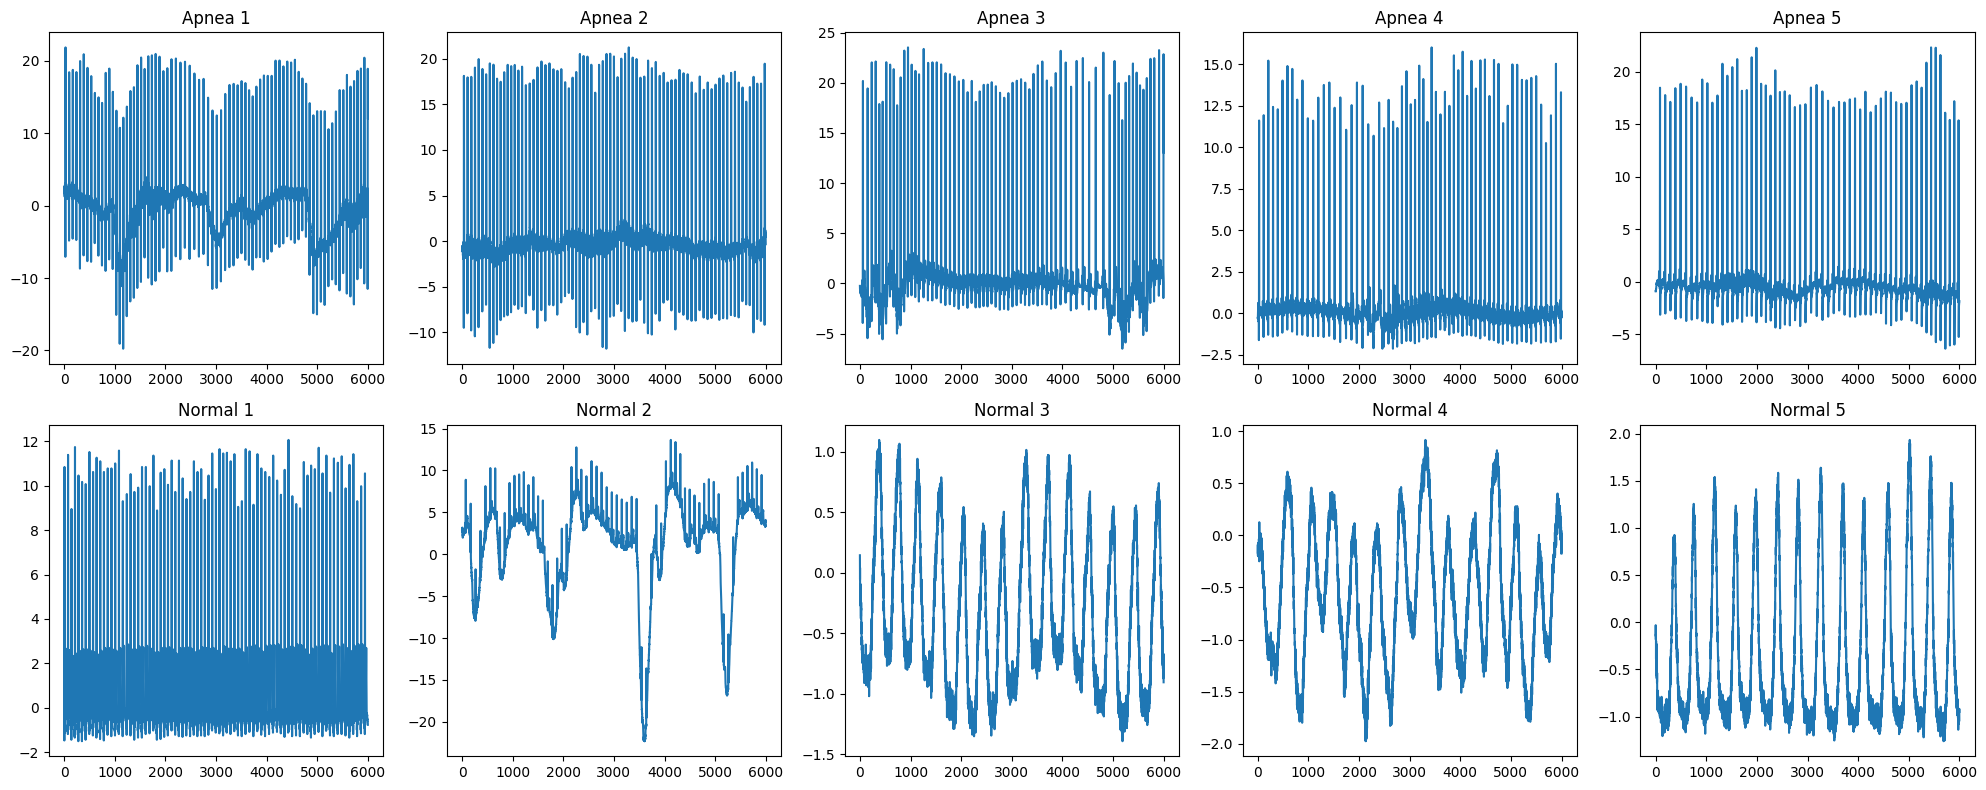

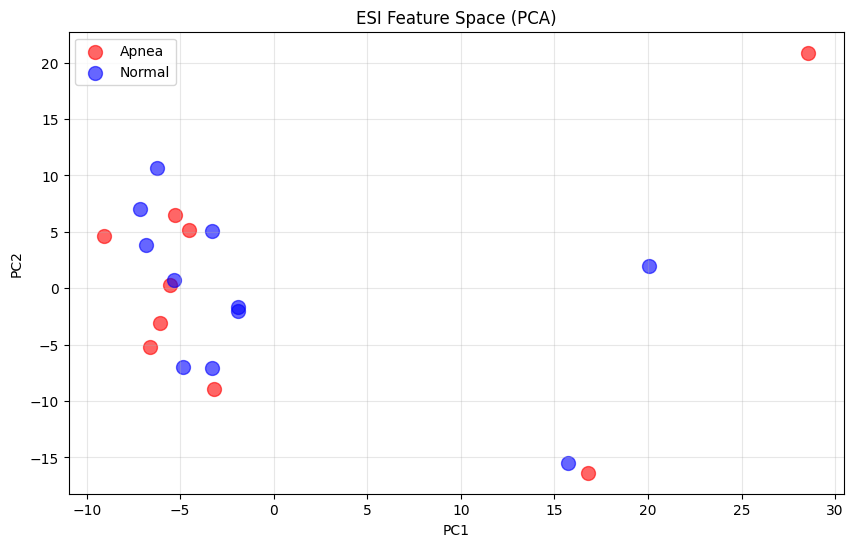

Variance explained: 44.90%


In [15]:
import matplotlib.pyplot as plt

# Visualize 10 apnea vs 10 normal samples
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(5):
    # Apnea samples
    apnea_idx = [idx for idx, (_, _, _, label) in enumerate(train_seg) if label == 1][i]
    signal, label = train_dataset[apnea_idx]
    axes[0, i].plot(signal.numpy().flatten())
    axes[0, i].set_title(f'Apnea {i+1}')
    
    # Normal samples
    normal_idx = [idx for idx, (_, _, _, label) in enumerate(train_seg) if label == 0][i]
    signal, label = train_dataset[normal_idx]
    axes[1, i].plot(signal.numpy().flatten())
    axes[1, i].set_title(f'Normal {i+1}')

plt.tight_layout()
plt.show()
def visualize_esi_features(model, test_dataset, device, n_samples=10):
    """
    Visualize what ESI backbone is extracting
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    model.eval()
    
    features_apnea = []
    features_normal = []
    
    # Get ESI features (before classification head)
    with torch.no_grad():
        for i in range(min(n_samples * 2, len(test_dataset))):
            signal, label = test_dataset[i]
            signal = signal.unsqueeze(0).to(device)
            
            # Extract ESI features
            x_multi = model.lead_projection(signal)
            x_multi = x_multi.permute(0, 2, 1)
            features = model.backbone(x_multi).cpu().numpy().flatten()
            
            if label == 1:
                features_apnea.append(features)
            else:
                features_normal.append(features)
    
    # Reduce to 2D
    all_features = np.vstack([features_apnea, features_normal])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_features)
    
    # Plot
    n_apnea = len(features_apnea)
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:n_apnea, 0], reduced[:n_apnea, 1], 
                c='red', label='Apnea', alpha=0.6, s=100)
    plt.scatter(reduced[n_apnea:, 0], reduced[n_apnea:, 1], 
                c='blue', label='Normal', alpha=0.6, s=100)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('ESI Feature Space (PCA)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")
visualize_esi_features(model, test_dataset, device)

In [30]:
# ==============================================================================
# CELL 9: Training Loop with Gradient Clipping & NaN Detection
# ==============================================================================

def train_one_epoch(model, train_loader, optimizer, criterion, scaler, device, epoch):
    """Train for one epoch with NaN detection"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    nan_count = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
    
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        
        # Check for NaN in data
        if torch.isnan(inputs).any() or torch.isnan(labels).any():
            print(f"⚠️ NaN in batch {batch_idx}, skipping...")
            nan_count += 1
            continue
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(inputs)
            
            # Check for NaN in outputs
            if torch.isnan(outputs).any():
                print(f"⚠️ NaN in outputs at batch {batch_idx}, skipping...")
                nan_count += 1
                continue
            
            loss = criterion(outputs, labels)
            
            # Check for NaN loss
            if torch.isnan(loss):
                print(f"⚠️ NaN loss at batch {batch_idx}, skipping...")
                nan_count += 1
                continue
        
        # Backward pass
        scaler.scale(loss).backward()
        
        # ADDED: Gradient clipping to prevent explosion
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    if nan_count > 0:
        print(f"⚠️ Encountered {nan_count} NaN batches this epoch")
    
    avg_loss = total_loss / max(len(train_loader) - nan_count, 1)
    accuracy = 100. * correct / total if total > 0 else 0
    
    return avg_loss, accuracy


def validate(model, val_loader, criterion, device):
    """Validation loop"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            # Skip NaN batches
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue
            
            outputs = model(inputs)
            
            if torch.isnan(outputs).any():
                continue
            
            loss = criterion(outputs, labels)
            
            if torch.isnan(loss):
                continue
            
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
    accuracy = 100. * correct / total if total > 0 else 0
    
    return avg_loss, accuracy


print("\n🚀 STEP 5: TRAINING (WITH FIXES)")
print("="*60)
print("Starting training loop...\n")

# Training loop
for epoch in range(config.NUM_EPOCHS):
    
    # Apply gradual unfreezing
    optimizer = apply_gradual_unfreezing(model, optimizer, config, epoch)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, scaler, config.DEVICE, epoch
    )
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, config.DEVICE)
    
    # Check for NaN
    if np.isnan(train_loss) or np.isnan(val_loss):
        print(f"\n❌ NaN detected at epoch {epoch+1}. Stopping training.")
        print("Possible causes:")
        print("1. Learning rate too high")
        print("2. Bad data normalization")
        print("3. Gradient explosion")
        break
    
    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step()
    
    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1}/{config.NUM_EPOCHS} Summary:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save checkpoint
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    save_checkpoint(model, optimizer, epoch, val_loss, history, is_best)
    
    # Early stopping
    # if patience_counter >= patience:
    #     print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
    #     break
    
    print("-" * 60)

print("\n✅ Training complete!")
print("="*60)



🚀 STEP 5: TRAINING (WITH FIXES)
Starting training loop...



Epoch 1/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a02r at 1302000-1308000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1401000-1407000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 363000-369000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 804000-810000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 618000-624000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 1110000-1116000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 297000-303000: Signal contains NaN or Inf
⚠️ Failed to load c02r at 99000-105000: Signal contains NaN or Inf
⚠️ Failed to load c02r at 483000-489000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1224000-1230000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-1

Epoch 2/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load c03r at 27000-33000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 156000-162000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 243000-249000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 21000-27000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1413000-1419000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1224000-1230000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 588000-594000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 1107000-1113000: Signal contains NaN or Inf
⚠️ Failed to load a01r at 42000-48000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 861000-867000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-1398000:

Epoch 3/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 666000-672000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1302000-1308000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 297000-303000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1227000-1233000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1224000-1230000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1080000-1086000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1458000-1464000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 156000-162000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 693000-699000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 48000-54000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-

Epoch 4/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load b01r at 363000-369000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 666000-672000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1269000-1275000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1083000-1089000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 801000-807000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 765000-771000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1413000-1419000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 504000-510000: Signal contains NaN or Inf
⚠️ Failed to load a01r at 1356000-1362000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1383000-1389000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 816000-822000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-

Epoch 5/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 222000-228000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 684000-690000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 504000-510000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 24000-30000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 159000-165000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 1110000-1116000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1122000-1128000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 363000-369000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1272000-1278000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 156000-162000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-1398

Epoch 6/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 765000-771000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 996000-1002000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 861000-867000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 132000-138000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1272000-1278000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 156000-162000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1269000-1275000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 297000-303000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 816000-822000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1086000-1092000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-1

Epoch 7/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a04r at 693000-699000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 504000-510000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 159000-165000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1458000-1464000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1395000-1401000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1086000-1092000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 861000-867000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 762000-768000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 993000-999000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 963000-969000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-13

Epoch 8/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a04r at 813000-819000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 507000-513000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1224000-1230000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 960000-966000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 159000-165000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 27000-33000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1104000-1110000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 132000-138000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 816000-822000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-1398

Epoch 9/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load c02r at 483000-489000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 816000-822000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1455000-1461000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 708000-714000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1086000-1092000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 243000-249000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 663000-669000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 762000-768000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1089000-1095000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 801000-807000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-13

Epoch 10/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 1401000-1407000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 765000-771000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 960000-966000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 708000-714000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 504000-510000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 993000-999000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 48000-54000: Signal contains NaN or Inf
⚠️ Failed to load c01r at 51000-57000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1080000-1086000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 801000-807000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-1398000:

Epoch 11/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 708000-714000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1362000-1368000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 504000-510000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1104000-1110000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 861000-867000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1413000-1419000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 132000-138000: Signal contains NaN or Inf
⚠️ Failed to load c01r at 51000-57000: Signal contains NaN or Inf
⚠️ Failed to load c02r at 483000-489000: Signal contains NaN or Inf
⚠️ Failed to load c02r at 99000-105000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-13980

Epoch 12/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 861000-867000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1401000-1407000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 693000-699000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1413000-1419000: Signal contains NaN or Inf
⚠️ Failed to load c02r at 99000-105000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 1110000-1116000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 963000-969000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1395000-1401000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 816000-822000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000

Epoch 13/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a02r at 1080000-1086000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 222000-228000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 156000-162000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 960000-966000: Signal contains NaN or Inf
⚠️ Failed to load c01r at 51000-57000: Signal contains NaN or Inf
⚠️ Failed to load a01r at 1353000-1359000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1122000-1128000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 363000-369000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 162000-168000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 27000-33000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 24000-30000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 132000-138000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Sig

Epoch 14/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load c03r at 156000-162000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 993000-999000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 159000-165000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 693000-699000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 693000-699000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1398000-1404000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 816000-822000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 297000-303000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 21000-27000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 861000-867000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-1398000:

Epoch 15/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 708000-714000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1395000-1401000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 804000-810000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 210000-216000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 366000-372000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 996000-1002000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1386000-1392000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 159000-165000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 861000-867000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 48000-54000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 591000-597000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1119000-1125000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1050000-1056000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1392000-13980

Epoch 16/25:   0%|          | 0/460 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 1395000-1401000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1416000-1422000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 210000-216000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 1107000-1113000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 687000-693000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1395000-1401000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 162000-168000: Signal contains NaN or Inf
⚠️ Failed to load a01r at 1353000-1359000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 765000-771000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1089000-1095000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1413000-1419000: Signal contains NaN or Inf


KeyboardInterrupt: 

In [21]:
def analyze_prediction_confidence(model, test_loader, device):
    """
    Find which samples model is uncertain about
    """
    model.eval()
    
    uncertain_samples = []
    confident_correct = []
    confident_wrong = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int).flatten()
            labels_np = labels.numpy()
            
            for i, (prob, pred, true_label) in enumerate(zip(probs.flatten(), preds, labels_np)):
                confidence = abs(prob - 0.5) * 2  # 0-1 scale
                
                # Uncertain predictions (confidence < 0.4)
                if confidence < 0.4:
                    uncertain_samples.append({
                        'probability': prob,
                        'prediction': pred,
                        'true_label': true_label,
                        'confidence': confidence
                    })
                # Confident predictions
                elif pred == true_label:
                    confident_correct.append(confidence)
                else:
                    confident_wrong.append({
                        'probability': prob,
                        'true_label': true_label,
                        'confidence': confidence
                    })
    
    print("📊 PREDICTION ANALYSIS")
    print("="*60)
    print(f"Uncertain samples: {len(uncertain_samples)}")
    print(f"Confident correct: {len(confident_correct)}")
    print(f"Confident wrong: {len(confident_wrong)}")
    
    if len(uncertain_samples) > 0:
        print(f"\n⚠️ {len(uncertain_samples)} samples are near decision boundary")
        print("These are inherently ambiguous cases")
    
    if len(confident_wrong) > 0:
        print(f"\n❌ {len(confident_wrong)} confident mistakes")
        print("These indicate model bias or data issues")
        
        # Show examples
        print("\nExamples of confident mistakes:")
        for item in confident_wrong[:5]:
            print(f"  Predicted {item['probability']:.3f}, True label: {item['true_label']}")
    
    return uncertain_samples, confident_correct, confident_wrong

In [22]:
import os
import time

def monitor_checkpoints():
    """Monitor checkpoint directory in real-time"""
    checkpoint_dir = "/kaggle/working/outputs/checkpoints"
    
    print("👀 Monitoring checkpoints...")
    print(f"Directory: {checkpoint_dir}")
    print("\nFiles currently saved:")
    
    if not os.path.exists(checkpoint_dir):
        print("❌ Checkpoint directory doesn't exist yet!")
        return
    
    files = os.listdir(checkpoint_dir)
    if len(files) == 0:
        print("⚠️ No checkpoint files found yet")
    else:
        for file in sorted(files):
            path = os.path.join(checkpoint_dir, file)
            size_mb = os.path.getsize(path) / (1024**2)
            mtime = time.ctime(os.path.getmtime(path))
            print(f"  ✓ {file}")
            print(f"    Size: {size_mb:.2f} MB")
            print(f"    Modified: {mtime}")
            print()

# Call this after a few epochs:
monitor_checkpoints()


👀 Monitoring checkpoints...
Directory: /kaggle/working/outputs/checkpoints

Files currently saved:
❌ Checkpoint directory doesn't exist yet!


In [16]:
import os

checkpoint_path = "/kaggle/input/model-checkpoints-apnea/outputs/checkpoints/best_model.pt"
print(f"File exists: {os.path.exists(checkpoint_path)}")

if os.path.exists(checkpoint_path):
    print(f"File size: {os.path.getsize(checkpoint_path) / (1024**2):.2f} MB")
    print("✅ Model was saved successfully!")
else:
    print("❌ Model file not found!")
    print("\nListing all files in outputs:")
    for root, dirs, files in os.walk("/kaggle/working/outputs"):
        for file in files:
            print(os.path.join(root, file))

File exists: True
File size: 576.43 MB
✅ Model was saved successfully!



📊 Plotting training history...


OSError: [Errno 30] Read-only file system: '/kaggle/input/model-checkpoints-apnea/outputs/training_history.png'

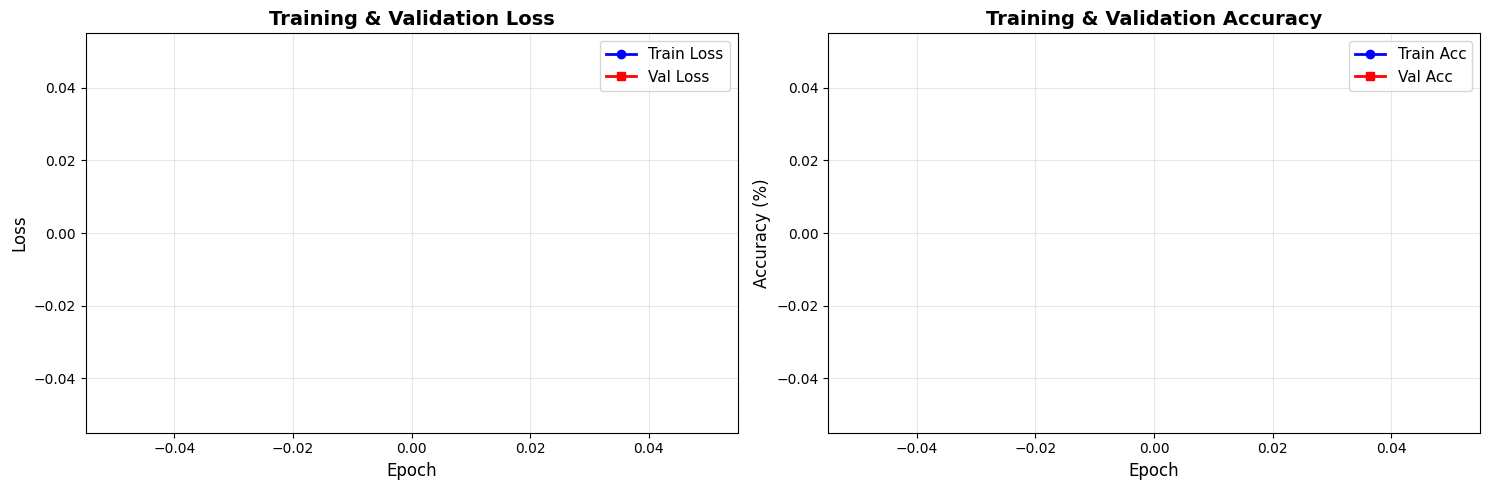

In [17]:
"""
CELL 10: Plot Training History (FIXED)
"""
print("\n📊 Plotting training history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
epochs_range = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs_range, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
ax2.plot(epochs_range, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# ✅ FIX: Save to /kaggle/working/ instead
save_path = '/kaggle/working/training_history.png'  # Changed from config.OUTPUT_DIR
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved to: {save_path}")
plt.show()

# Print final stats
print(f"\n📈 Final Training Statistics:")
print(f"   Best Val Loss:    {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss']))+1})")
print(f"   Best Val Acc:     {max(history['val_acc']):.2f}% (Epoch {history['val_acc'].index(max(history['val_acc']))+1})")
print(f"   Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"   Final Val Loss:   {history['val_loss'][-1]:.4f}")

In [27]:
# ==============================================================================
# CELL 11: Model evaluation
# ==============================================================================

print("\n🔍 STEP 6: FINAL EVALUATION")
print("="*60)

# Load best model
print("Loading best model checkpoint...")
best_checkpoint = torch.load(
    os.path.join(config.OUTPUT_DIR, "checkpoints", "best_model.pt")
)
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {best_checkpoint['epoch']+1}")

# Evaluation
model.eval()

all_preds = []
all_probs = []
all_labels = []

print("\nEvaluating on test set...")

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(config.DEVICE)
        
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        
        all_preds.extend(preds.flatten())
        all_probs.extend(probs.flatten())
        all_labels.extend(labels.numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute metrics
def compute_metrics(y_true, y_pred, y_prob):
    """Compute comprehensive metrics"""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = np.mean(y_true == y_pred)
    metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Clinical metrics
    metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['ppv'] = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
    metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    
    return metrics

metrics = compute_metrics(all_labels, all_preds, all_probs)

# Print results
print("\n" + "="*60)
print("🏆 FINAL TEST RESULTS")
print("="*60)

print(f"\n📊 Overall Metrics:")
print(f"   Accuracy:     {metrics['accuracy']:.4f}")
print(f"   ROC-AUC:      {metrics['roc_auc']:.4f}")
print(f"   F1 Score:     {metrics['f1_score']:.4f}")
print(f"   MCC:          {metrics['mcc']:.4f}")

print(f"\n🎯 Clinical Metrics:")
print(f"   Sensitivity:  {metrics['sensitivity']:.4f} (True Positive Rate)")
print(f"   Specificity:  {metrics['specificity']:.4f} (True Negative Rate)")
print(f"   PPV:          {metrics['ppv']:.4f} (Precision)")
print(f"   NPV:          {metrics['npv']:.4f} (Negative Predictive Value)")

print(f"\n📋 Confusion Matrix:")
print(metrics['confusion_matrix'])

print(f"\n📝 Classification Report:")
print(classification_report(all_labels, all_preds, 
                           target_names=['Normal', 'Apnea'],
                           digits=4))

print("="*60)


🔍 STEP 6: FINAL EVALUATION
Loading best model checkpoint...
✅ Loaded best model from epoch 4

Evaluating on test set...


Testing:   0%|          | 0/132 [00:00<?, ?it/s]

⚠️ Failed to load a03r at 300000-306000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 294000-300000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 1389000-1395000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1053000-1059000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 240000-246000: Signal contains NaN or Inf
⚠️ Failed to load a01r at 45000-51000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 45000-51000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 198000-204000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 705000-711000: Signal contains NaN or Inf

🏆 FINAL TEST RESULTS

📊 Overall Metrics:
   Accuracy:     0.8143
   ROC-AUC:      0.8979
   F1 Score:     0.7484
   MCC:          0.6035

🎯 Clinical Metrics:
   Sensitivity:  0.7138 (True Positive Rate)
   Specificity:  0.8777 (True Negative Rate)
   PPV:          0.7864 (Precision)
   NPV:          0.8294 (Negative Predictive Value)

📋 Confusion Matrix:
[[2260  315]
 [ 465 1160]]

📝 


📊 Creating evaluation plots...


OSError: [Errno 30] Read-only file system: '/kaggle/input/model-checkpoints-apnea/outputs/evaluation_plots.png'

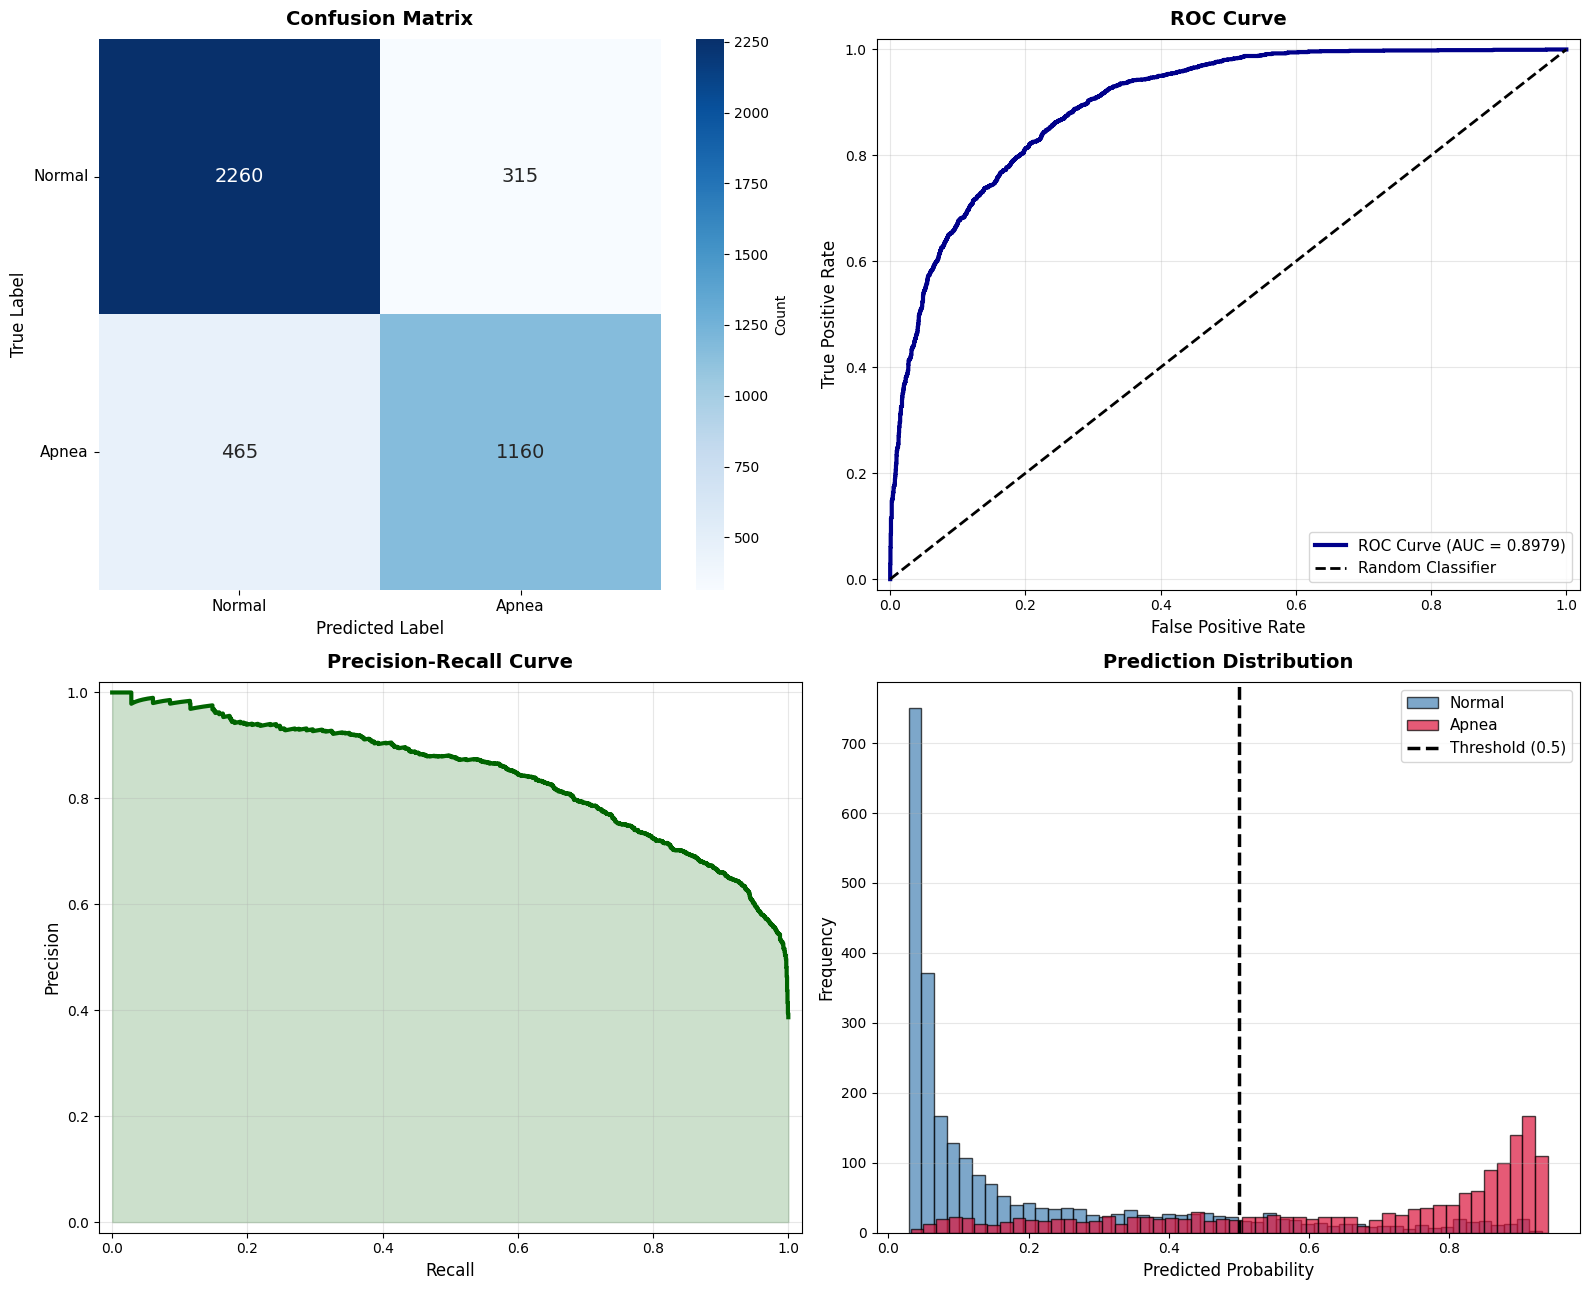

In [28]:
# ==============================================================================
# CELL 12:Plotting stuff
# ==============================================================================

print("\n📊 Creating evaluation plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 13))

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], 
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=10)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xticklabels(['Normal', 'Apnea'], fontsize=11)
axes[0, 0].set_yticklabels(['Normal', 'Apnea'], fontsize=11, rotation=0)

# 2. ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

axes[0, 1].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkblue')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold', pad=10)
axes[0, 1].legend(fontsize=11, loc='lower right')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([-0.02, 1.02])
axes[0, 1].set_ylim([-0.02, 1.02])

# 3. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

axes[1, 0].plot(recall, precision, linewidth=3, color='darkgreen')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([-0.02, 1.02])
axes[1, 0].set_ylim([-0.02, 1.02])
axes[1, 0].fill_between(recall, precision, alpha=0.2, color='darkgreen')

# 4. Prediction Distribution
axes[1, 1].hist(all_probs[all_labels == 0], bins=50, alpha=0.7, 
                label='Normal', color='steelblue', edgecolor='black')
axes[1, 1].hist(all_probs[all_labels == 1], bins=50, alpha=0.7, 
                label='Apnea', color='crimson', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2.5, 
                   label='Threshold (0.5)')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Prediction Distribution', fontsize=14, fontweight='bold', pad=10)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save figure
# save_path = os.path.join(config.OUTPUT_DIR, 'evaluation_plots.png')
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
# print(f"✅ Plots saved to: {save_path}")
plt.show()

print("\n📁 All outputs saved to:", config.OUTPUT_DIR)


🔮 STEP 7: INFERENCE DEMO

Testing on random samples from test set:

Sample 1:
   True Label:    Normal
   Predicted:     Normal
   Confidence:    0.3106
   Correct:       ✅

Sample 2:
   True Label:    Normal
   Predicted:     Normal
   Confidence:    0.3740
   Correct:       ✅

Sample 3:
   True Label:    Normal
   Predicted:     Normal
   Confidence:    0.4236
   Correct:       ✅

Sample 4:
   True Label:    Normal
   Predicted:     Normal
   Confidence:    0.3730
   Correct:       ✅

Sample 5:
   True Label:    Apnea
   Predicted:     Normal
   Confidence:    0.3572
   Correct:       ❌


📊 Visualizing sample ECG segment with prediction...



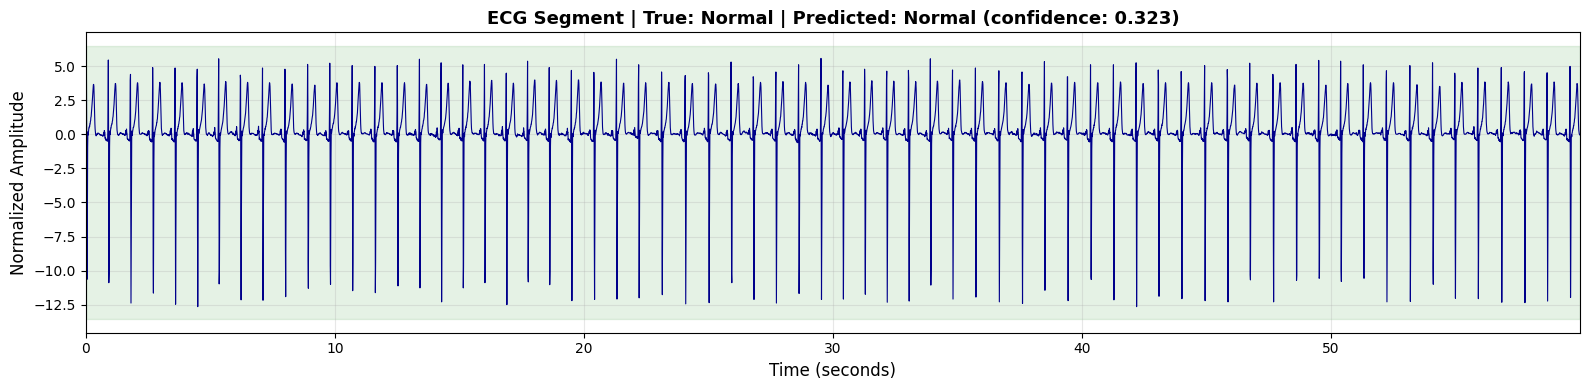

✅ Inference demo complete!


In [19]:
# ==============================================================================
# CELL 13: Inference Demo
# ==============================================================================

print("\n🔮 STEP 7: INFERENCE DEMO")
print("="*60)

def predict_single_sample(model, ecg_signal, device):
    """
    Predict on a single ECG segment
    
    Args:
        model: Trained model
        ecg_signal: Tensor of shape [1, seq_length]
        device: torch device
    
    Returns:
        probability, prediction
    """
    model.eval()
    
    signal_tensor = ecg_signal.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(signal_tensor)
        prob = torch.sigmoid(output).cpu().item()
        pred = 1 if prob > 0.5 else 0
    
    return prob, pred


# Test on random samples from test set
print("\nTesting on random samples from test set:\n")

num_samples = 5
for i in range(num_samples):
    # Get random sample
    idx = np.random.randint(0, len(test_dataset))
    sample_signal, true_label = test_dataset[idx]
    
    # Predict
    prob, pred = predict_single_sample(model, sample_signal, config.DEVICE)
    
    # Display results
    true_class = 'Apnea' if true_label == 1 else 'Normal'
    pred_class = 'Apnea' if pred == 1 else 'Normal'
    correct = '✅' if pred == true_label else '❌'
    
    print(f"Sample {i+1}:")
    print(f"   True Label:    {true_class}")
    print(f"   Predicted:     {pred_class}")
    print(f"   Confidence:    {prob:.4f}")
    print(f"   Correct:       {correct}")
    print()

print("="*60)


# Visualize a sample prediction
print("\n📊 Visualizing sample ECG segment with prediction...\n")

# Get a sample
idx = np.random.randint(0, len(test_dataset))
sample_signal, true_label = test_dataset[idx]
prob, pred = predict_single_sample(model, sample_signal, config.DEVICE)

# Plot
fig, ax = plt.subplots(figsize=(16, 4))

# Denormalize for visualization (approximate)
signal_np = sample_signal.numpy().flatten()

time_axis = np.arange(len(signal_np)) / config.FS  # Time in seconds

ax.plot(time_axis, signal_np, linewidth=0.8, color='darkblue')
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Normalized Amplitude', fontsize=12)
ax.set_title(f'ECG Segment | True: {"Apnea" if true_label==1 else "Normal"} | '
             f'Predicted: {"Apnea" if pred==1 else "Normal"} (confidence: {prob:.3f})',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, time_axis[-1]])

# Add background color based on prediction
if pred == 1:
    ax.axhspan(ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.1, color='red')
else:
    ax.axhspan(ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.1, color='green')

plt.tight_layout()
plt.show()

print("✅ Inference demo complete!")

In [31]:
# ==============================================================================
# CELL 14: Save final model
# ==============================================================================

print("\n💾 STEP 8: SAVING FINAL MODEL")
print("="*60)

# Save to working directory (temporary)
final_model_path = os.path.join(config.OUTPUT_DIR, "final_model.pt")

# IMPORTANT: Use weights_only compatible format
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'seq_length': config.SEQ_LENGTH,
        'esi_embedding_dim': config.ESI_EMBEDDING_DIM,
        'hidden_dim': config.HIDDEN_DIM,
        'lstm_layers': config.LSTM_LAYERS,
        'dropout': config.DROPOUT,
    },
    'normalization': {
        'mean': float(dataset_mean),  # Convert to native Python types
        'std': float(dataset_std)
    },
    'epoch': best_checkpoint['epoch'],
    'val_loss': float(best_val_loss)
}, final_model_path)

print(f"✅ Model saved to: {final_model_path}")

# Also save just weights (smaller file)
weights_path = os.path.join(config.OUTPUT_DIR, "model_weights.pt")
torch.save(model.state_dict(), weights_path)
print(f"✅ Weights saved to: {weights_path}")

# Save metrics to text file
metrics_path = os.path.join(config.OUTPUT_DIR, "test_metrics.txt")
with open(metrics_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("SLEEP APNEA DETECTION - TEST RESULTS\n")
    f.write("="*60 + "\n\n")
    
    f.write("Overall Metrics:\n")
    f.write(f"  Accuracy:     {metrics['accuracy']:.4f}\n")
    f.write(f"  ROC-AUC:      {metrics['roc_auc']:.4f}\n")
    f.write(f"  F1 Score:     {metrics['f1_score']:.4f}\n")
    f.write(f"  MCC:          {metrics['mcc']:.4f}\n\n")
    
    f.write("Clinical Metrics:\n")
    f.write(f"  Sensitivity:  {metrics['sensitivity']:.4f}\n")
    f.write(f"  Specificity:  {metrics['specificity']:.4f}\n")
    f.write(f"  PPV:          {metrics['ppv']:.4f}\n")
    f.write(f"  NPV:          {metrics['npv']:.4f}\n\n")
    
    f.write("Confusion Matrix:\n")
    f.write(f"{metrics['confusion_matrix']}\n\n")
    
    f.write("Classification Report:\n")
    f.write(classification_report(all_labels, all_preds, 
                                 target_names=['Normal', 'Apnea'],
                                 digits=4))

print(f"✅ Metrics saved to: {metrics_path}")

print("\n📁 All files saved to:", config.OUTPUT_DIR)
print("   - final_model.pt (complete model + config)")
print("   - model_weights.pt (weights only)")
print("   - best_model.pt (best checkpoint)")
print("   - training_history.png")
print("   - evaluation_plots.png")
print("   - test_metrics.txt")

print("\n" + "="*60)
print("🎉 PIPELINE COMPLETE!")
print("="*60)


💾 STEP 8: SAVING FINAL MODEL


RuntimeError: File /kaggle/input/model-checkpoints-apnea/outputs/final_model.pt cannot be opened.

In [20]:
# ==============================================================================
# CELL 15: Load and Use best Model
# ==============================================================================

print("\nLOADING SAVED MODEL FOR INFERENCE")
print("="*60)

# Function to load saved model
def load_trained_model(model_path, device):
    """Load model with proper error handling"""
    try:
        # FIX: Add weights_only=False for PyTorch 2.6+
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        
        # Extract config
        model_config = checkpoint['config']
        normalization = checkpoint['normalization']
        
        # Create config object
        class SavedConfig:
            SEQ_LENGTH = model_config['seq_length']
            ESI_EMBEDDING_DIM = model_config['esi_embedding_dim']
            HIDDEN_DIM = model_config['hidden_dim']
            LSTM_LAYERS = model_config['lstm_layers']
            DROPOUT = model_config['dropout']
            DEVICE = device
        
        saved_config = SavedConfig()
        
        # Reinitialize model
        model = ESIApneaDetector(config.CHECKPOINT_PATH, saved_config)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
        
        return model, saved_config, normalization
    
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

# Example: Load the saved model
try:
    final_model_path = os.path.join(config.OUTPUT_DIR, "final_model.pt")
    loaded_model, loaded_config, norm_params = load_trained_model(
        final_model_path, 
        config.DEVICE
    )
    print(f"✅ Model loaded successfully from: {final_model_path}")
    print(f"   Normalization - Mean: {norm_params['mean']:.6f}, Std: {norm_params['std']:.6f}")
except Exception as e:
    print(f"⚠️ Could not load model: {e}")


# Function to preprocess and predict on new ECG data
def predict_ecg(model, ecg_signal_raw, mean, std, device):
    """
    Preprocess and predict on raw ECG signal
    
    Args:
        model: Trained model
        ecg_signal_raw: Raw ECG signal (numpy array, shape [seq_length,])
        mean: Dataset mean for normalization
        std: Dataset std for normalization
        device: torch device
    
    Returns:
        probability, prediction, confidence_level
    """
    model.eval()
    
    # Ensure correct length
    if len(ecg_signal_raw) != loaded_config.SEQ_LENGTH:
        if len(ecg_signal_raw) < loaded_config.SEQ_LENGTH:
            # Pad
            pad_length = loaded_config.SEQ_LENGTH - len(ecg_signal_raw)
            ecg_signal_raw = np.pad(ecg_signal_raw, (0, pad_length), mode='edge')
        else:
            # Crop
            ecg_signal_raw = ecg_signal_raw[:loaded_config.SEQ_LENGTH]
    
    # Normalize
    ecg_normalized = (ecg_signal_raw - mean) / (std + 1e-8)
    
    # Convert to tensor [1, 1, seq_length]
    ecg_tensor = torch.tensor(ecg_normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    ecg_tensor = ecg_tensor.to(device)
    
    # Predict
    with torch.no_grad():
        output = model(ecg_tensor)
        prob = torch.sigmoid(output).cpu().item()
        pred = 1 if prob > 0.5 else 0
    
    # Determine confidence level
    if abs(prob - 0.5) < 0.2:
        confidence = "Low"
    elif abs(prob - 0.5) < 0.3:
        confidence = "Medium"
    else:
        confidence = "High"
    
    return prob, pred, confidence


print("\n🧪 Testing loaded model on a sample...\n")

# Get a test sample
idx = np.random.randint(0, len(test_dataset))
sample_signal, true_label = test_dataset[idx]

# Denormalize (to simulate raw data)
sample_raw = sample_signal.numpy().flatten() * dataset_std + dataset_mean

# Predict using the loaded model and preprocessing function
prob, pred, confidence = predict_ecg(
    loaded_model,
    sample_raw,
    norm_params['mean'],
    norm_params['std'],
    config.DEVICE
)

print(f"Sample Test:")
print(f"   True Label:       {'Apnea' if true_label == 1 else 'Normal'}")
print(f"   Predicted:        {'Apnea' if pred == 1 else 'Normal'}")
print(f"   Probability:      {prob:.4f}")
print(f"   Confidence Level: {confidence}")
print(f"   Correct:          {'✅' if pred == true_label else '❌'}")

print("\n" + "="*60)
print("💡 TIP: Use the 'predict_ecg()' function to predict on new ECG data!")
print("="*60)

# Example usage code
print("\n📝 Example Usage Code:")
print("""
# Load model
model, config, norm_params = load_trained_model('outputs/final_model.pt', device)

# Predict on new ECG signal (numpy array of length 6000)
prob, pred, confidence = predict_ecg(
    model, 
    your_ecg_signal,  # Shape: [6000,]
    norm_params['mean'],
    norm_params['std'],
    device
)

# Result
if pred == 1:
    print(f"Apnea detected with {prob*100:.1f}% confidence!")
else:
    print(f"Normal breathing with {(1-prob)*100:.1f}% confidence!")
""")

print("\n✅ All done! Your model is ready for deployment!")


🔄 BONUS: LOADING SAVED MODEL FOR INFERENCE
✅ ESI weights loaded successfully
✅ Model loaded successfully from: /kaggle/input/model-checkpoints-apnea/outputs/final_model.pt
   Normalization - Mean: -0.042272, Std: 0.166786

🧪 Testing loaded model on a sample...

Sample Test:
   True Label:       Normal
   Predicted:        Normal
   Probability:      0.0358
   Confidence Level: High
   Correct:          ✅

💡 TIP: Use the 'predict_ecg()' function to predict on new ECG data!

📝 Example Usage Code:

# Load model
model, config, norm_params = load_trained_model('outputs/final_model.pt', device)

# Predict on new ECG signal (numpy array of length 6000)
prob, pred, confidence = predict_ecg(
    model, 
    your_ecg_signal,  # Shape: [6000,]
    norm_params['mean'],
    norm_params['std'],
    device
)

# Result
if pred == 1:
    print(f"Apnea detected with {prob*100:.1f}% confidence!")
else:
    print(f"Normal breathing with {(1-prob)*100:.1f}% confidence!")


✅ All done! Your model is ready 

In [21]:
!pip install pyngrok

In [24]:
!pip install flask_cors

In [25]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok, conf
from kaggle_secrets import UserSecretsClient # <--- Import this
import numpy as np
import torch
import wfdb
from werkzeug.utils import secure_filename
from datetime import datetime
import traceback


In [26]:
# ============================================================================
# COMPLETE FLASK INFERENCE SETUP (WITH STATIC NGROK URL)
# ============================================================================

import os
import sys

# Kill existing ngrok
os.system("killall ngrok")
os.system('pip install -q flask flask-cors pyngrok')

# ============================================================================
# IMPORTS
# ============================================================================
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok, conf
from kaggle_secrets import UserSecretsClient
import numpy as np
import torch
import wfdb
from werkzeug.utils import secure_filename
from datetime import datetime
import traceback

# ============================================================================
# 🔐 NGROK AUTH & STATIC DOMAIN SETUP
# ============================================================================
try:
    user_secrets = UserSecretsClient()
    NGROK_AUTH_TOKEN = user_secrets.get_secret("NGROK_AUTH_TOKEN")
    
    # 🆕 RETRIEVE STATIC DOMAIN FROM SECRETS
    # Add this as a Secret in Kaggle: Key="NGROK_STATIC_DOMAIN", Value="your-domain.ngrok-free.app"
    NGROK_STATIC_DOMAIN = user_secrets.get_secret("NGROK_STATIC_DOMAIN")
    
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    conf.get_default().region = "us"
    print("✅ Ngrok token loaded")
    print(f"✅ Static domain loaded: {NGROK_STATIC_DOMAIN}")
except Exception as e:
    print(f"❌ Secret retrieval failed: {e}")
    print("Make sure you added both:")
    print("  1. NGROK_AUTH_TOKEN")
    print("  2. NGROK_STATIC_DOMAIN (format: your-domain.ngrok-free.app)")
    raise

# ============================================================================
# 📊 CALCULATE OR LOAD NORMALIZATION PARAMETERS
# ============================================================================
print("\n" + "="*70)
print("📊 LOADING NORMALIZATION PARAMETERS")
print("="*70)

try:
    # OPTION 1: Load from checkpoint (RECOMMENDED)
    checkpoint = torch.load('/path/to/checkpoint.pth', map_location=device)
    
    if 'normalization_params' in checkpoint:
        normalization_params = checkpoint['normalization_params']
        print(f"✅ Loaded from checkpoint:")
    else:
        raise KeyError("Not in checkpoint")
        
except:
    # OPTION 2: Calculate from training data
    try:
        print("⚠️  Calculating from training data...")
        all_signals = []
        
        # Collect signals from training loader
        for batch_idx, (signals, _) in enumerate(train_loader):
            all_signals.append(signals.numpy())
            if batch_idx >= 100:  # Limit to first 100 batches for speed
                break
        
        all_signals = np.concatenate(all_signals, axis=0)
        normalization_params = {
            'mean': float(np.mean(all_signals)),
            'std': float(np.std(all_signals))
        }
        print(f"✅ Calculated from data:")
        
    except:
        # OPTION 3: Use safe defaults for ECG
        print("⚠️  Using default ECG normalization values")
        normalization_params = {
            'mean': 0.0,
            'std': 1.0
        }
        print(f"✅ Using defaults:")

print(f"   Mean: {normalization_params['mean']:.6f}")
print(f"   Std:  {normalization_params['std']:.6f}")
print("="*70 + "\n")

# ============================================================================
# FLASK APP SETUP
# ============================================================================
app = Flask(__name__)
CORS(app)

UPLOAD_FOLDER = '/tmp/ecg_uploads'
ALLOWED_EXTENSIONS = {'hea', 'dat'}
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

def extract_demographics(record_path):
    try:
        header = wfdb.rdheader(record_path)
        demographics = {
            'record_name': header.record_name,
            'sampling_frequency': f"{header.fs} Hz",
            'signal_length': f"{header.sig_len} samples",
            'duration': f"{header.sig_len / header.fs:.1f} seconds",
            'number_of_signals': header.n_sig,
        }
        if hasattr(header, 'comments') and header.comments:
            for comment in header.comments:
                comment_lower = comment.lower()
                if 'age' in comment_lower: 
                    demographics['age'] = comment
                elif 'sex' in comment_lower or 'gender' in comment_lower: 
                    demographics['gender'] = comment
        return demographics
    except Exception as e: 
        return {'error': str(e)}

def generate_waveform_points(signal, target_points=800):
    try:
        downsample_factor = max(1, len(signal) // target_points)
        signal_viz = signal[::downsample_factor]
        signal_min, signal_max = signal_viz.min(), signal_viz.max()
        
        if abs(signal_max - signal_min) < 1e-6:
            signal_normalized = np.full_like(signal_viz, 50.0)
        else:
            signal_normalized = 100 - ((signal_viz - signal_min) / (signal_max - signal_min) * 80 + 10)
        
        x_scale = 800 / len(signal_normalized)
        points = [f"{i * x_scale:.2f},{y:.2f}" for i, y in enumerate(signal_normalized)]
        return " ".join(points)
    except Exception as e: 
        return "0,50 800,50"

def preprocess_signal(signal, mean, std, seq_length=6000):
    """
    Preprocess ECG signal for model inference
    """
    try:
        # Handle multi-channel signals
        if signal.ndim > 1: 
            signal = signal[:, 0]
        
        # Pad or truncate to fixed length
        if len(signal) < seq_length: 
            signal = np.pad(signal, (0, seq_length - len(signal)), mode='edge')
        elif len(signal) > seq_length: 
            signal = signal[:seq_length]
        
        # Normalize using provided parameters
        signal_normalized = (signal - mean) / (std + 1e-8)
        
        # Convert to tensor with shape [batch, channels, length]
        return torch.tensor(signal_normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    except Exception as e: 
        print(f"❌ Preprocessing error: {e}")
        return None

def run_inference(model, signal_tensor, device):
    """
    Run model inference and return prediction
    """
    try:
        model.eval()
        with torch.no_grad():
            output = model(signal_tensor.to(device))
            raw_logit = output.cpu().item()
            probability = torch.sigmoid(output).cpu().item()
        
        has_apnea = probability > 0.5
        
        # Enhanced logging
        print(f"\n{'='*50}")
        print(f"🔍 INFERENCE RESULTS:")
        print(f"{'='*50}")
        print(f"Raw Logit:    {raw_logit:.4f}")
        print(f"Probability:  {probability:.4f}")
        print(f"Has Apnea:    {has_apnea}")
        print(f"{'='*50}\n")
        
        # Calculate risk metrics
        risk_level = "High Risk" if probability > 0.7 else "Moderate Risk" if probability > 0.4 else "Low Risk"
        risk_color = "danger" if probability > 0.7 else "warning" if probability > 0.4 else "success"
        
        result = {
            'has_apnea': bool(has_apnea),
            'probability': float(probability),
            'raw_logit': float(raw_logit),
            'risk_level': risk_level,
            'risk_color': risk_color,
            'diagnosis': 'Apnea Detected' if has_apnea else 'Normal'
        }
        
        print(f"📤 Returning: {result}")
        return result
        
    except Exception as e: 
        print(f"❌ Inference error: {e}")
        traceback.print_exc()
        return None

# ============================================================================
# API ENDPOINTS
# ============================================================================

@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({
        'status': 'healthy',
        'model_loaded': model is not None,
        'device': str(device),
        'gpu_available': torch.cuda.is_available(),
        'normalization': normalization_params
    })

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Validation
        if model is None: 
            return jsonify({'success': False, 'error': 'Model not loaded.'}), 500
        
        if 'files' not in request.files: 
            return jsonify({'success': False, 'error': 'No files uploaded.'}), 400
        
        files = request.files.getlist('files')
        hea_file = next((f for f in files if f.filename.endswith('.hea')), None)
        dat_file = next((f for f in files if f.filename.endswith('.dat')), None)
        
        if not hea_file or not dat_file: 
            return jsonify({'success': False, 'error': 'Missing .hea or .dat file.'}), 400
        
        # Save files
        base_name = secure_filename(hea_file.filename).rsplit('.', 1)[0]
        hea_path = os.path.join(UPLOAD_FOLDER, f"{base_name}.hea")
        dat_path = os.path.join(UPLOAD_FOLDER, f"{base_name}.dat")
        hea_file.save(hea_path)
        dat_file.save(dat_path)
        
        print(f"\n📁 Processing: {base_name}")
        
        # Load and process signal
        record_path = os.path.join(UPLOAD_FOLDER, base_name)
        demographics = extract_demographics(record_path)
        signal, _ = wfdb.rdsamp(record_path, sampfrom=0, sampto=6000)
        
        # Generate waveform visualization
        raw_signal = signal[:, 0] if signal.ndim > 1 else signal
        waveform_points = generate_waveform_points(raw_signal)
        
        # Preprocess and run inference
        signal_tensor = preprocess_signal(
            signal, 
            normalization_params['mean'], 
            normalization_params['std']
        )
        
        if signal_tensor is None:
            return jsonify({'success': False, 'error': 'Signal preprocessing failed'}), 500
        
        prediction_result = run_inference(model, signal_tensor, device)
        
        if prediction_result is None:
            return jsonify({'success': False, 'error': 'Inference failed'}), 500
        
        # Build response
        response = {
            'success': True,
            'prediction': prediction_result,
            'demographics': demographics,
            'waveform': waveform_points,
            'timestamp': datetime.utcnow().isoformat()
        }
        
        # Cleanup
        try: 
            os.remove(hea_path)
            os.remove(dat_path)
        except: 
            pass
        
        print(f"✅ Analysis complete: {prediction_result['diagnosis']}")
        return jsonify(response), 200
        
    except Exception as e:
        print(f"\n❌ ERROR IN /predict:")
        traceback.print_exc()
        return jsonify({'success': False, 'error': str(e)}), 500

# ============================================================================
# START SERVER WITH STATIC NGROK URL
# ============================================================================

def start_inference_server():
    print("\n" + "="*70)
    print("🚀 STARTING INFERENCE SERVER")
    print("="*70)
    
    if model is None:
        print("❌ ERROR: Model not loaded!")
        return
    
    try:
        port = 5000
        
        # 🆕 CONNECT USING STATIC DOMAIN
        public_url = ngrok.connect(
            port, 
            bind_tls=True,
            hostname=NGROK_STATIC_DOMAIN  # Uses your reserved domain
        )
        
        print("\n" + "="*70)
        print("🌐 SERVER READY (STATIC URL)")
        print("="*70)
        print(f"🌍 Public URL: https://{NGROK_STATIC_DOMAIN}")
        print(f"🔍 Health Check: https://{NGROK_STATIC_DOMAIN}/health")
        print(f"📡 Predict Endpoint: https://{NGROK_STATIC_DOMAIN}/predict")
        print("="*70 + "\n")
        
        app.run(host='0.0.0.0', port=port, debug=False, use_reloader=False)
        
    except Exception as e:
        print(f"\n❌ Server start failed: {e}")
        traceback.print_exc()

# ============================================================================
# AUTO-START
# ============================================================================

if 'model' in globals() and model is not None:
    start_inference_server()
else:
    print("⚠️ Model not found. Run training cells first.")

ngrok: no process found


✅ Ngrok token loaded                                                                                
✅ Static domain loaded: merry-ewe-endlessly.ngrok-free.app

📊 LOADING NORMALIZATION PARAMETERS
⚠️  Calculating from training data...
⚠️ Failed to load b01r at 960000-966000: Signal contains NaN or Inf
⚠️ Failed to load a03r at 765000-771000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 297000-303000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 816000-822000: Signal contains NaN or Inf
⚠️ Failed to load a02r at 1089000-1095000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 48000-54000: Signal contains NaN or Inf
⚠️ Failed to load c03r at 27000-33000: Signal contains NaN or Inf
⚠️ Failed to load a04r at 1047000-1053000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 129000-135000: Signal contains NaN or Inf
⚠️ Failed to load b01r at 963000-969000: Signal contains NaN or Inf
✅ Calculated from data:
   Mean: 0.191753
   Std:  3.124239


🚀 STARTING INFERENCE SER

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.19.2.2:5000
Press CTRL+C to quit
127.0.0.1 - - [14/Dec/2025 12:20:18] "POST /predict HTTP/1.1" 200 -



📁 Processing: a01

🔍 INFERENCE RESULTS:
Raw Logit:    -0.8222
Probability:  0.3053
Has Apnea:    False

📤 Returning: {'has_apnea': False, 'probability': 0.30529728531837463, 'raw_logit': -0.8221980929374695, 'risk_level': 'Low Risk', 'risk_color': 'success', 'diagnosis': 'Normal'}
✅ Analysis complete: Normal


127.0.0.1 - - [14/Dec/2025 12:20:59] "POST /predict HTTP/1.1" 200 -



📁 Processing: a03

🔍 INFERENCE RESULTS:
Raw Logit:    0.0928
Probability:  0.5232
Has Apnea:    True

📤 Returning: {'has_apnea': True, 'probability': 0.5231823921203613, 'raw_logit': 0.09279607236385345, 'risk_level': 'Moderate Risk', 'risk_color': 'warning', 'diagnosis': 'Apnea Detected'}
✅ Analysis complete: Apnea Detected


127.0.0.1 - - [14/Dec/2025 12:21:17] "POST /predict HTTP/1.1" 200 -



📁 Processing: a04

🔍 INFERENCE RESULTS:
Raw Logit:    0.4349
Probability:  0.6070
Has Apnea:    True

📤 Returning: {'has_apnea': True, 'probability': 0.607049286365509, 'raw_logit': 0.43492594361305237, 'risk_level': 'Moderate Risk', 'risk_color': 'warning', 'diagnosis': 'Apnea Detected'}
✅ Analysis complete: Apnea Detected


127.0.0.1 - - [14/Dec/2025 12:21:32] "POST /predict HTTP/1.1" 200 -



📁 Processing: c05

🔍 INFERENCE RESULTS:
Raw Logit:    -0.9252
Probability:  0.2839
Has Apnea:    False

📤 Returning: {'has_apnea': False, 'probability': 0.28390464186668396, 'raw_logit': -0.9251748323440552, 'risk_level': 'Low Risk', 'risk_color': 'success', 'diagnosis': 'Normal'}
✅ Analysis complete: Normal


In [27]:
ngrok.kill()